In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [3]:
file = "Entrenamieto_ECI_2020.csv"
data = pd.read_csv(file)
data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [4]:
borrar = ["Opportunity_Name", "ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]
useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]
clear = ["Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Modified_Date", "Product_Type", 
         "Opportunity_Created_Date", "Quote_Type", "Account_Created_Date"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [5]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    # Contacts: la cantidad de negociaciones registradas
    # Delivery_difference: la cantidad de dias entre las fechas planeadas final e inicial de delivery
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    # limpio columnas
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
    
    data = data.drop(borrar + useless + dates, axis = 1)    
    
    return (data)

In [6]:
df = preprocess(data)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A']
categorical = [x for x in categorical if x in df.columns]

In [8]:
train_data = lgb.Dataset(x_train.drop(target, axis = 1), label = y_train, categorical_feature = categorical)
test_data = lgb.Dataset(x_test.drop(target, axis = 1), label = y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 800)

/home/eugenio/.local/lib/python2.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/eugenio/.local/lib/python2.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Account_Owner', 'Billing_Country', 'Bureaucratic_Code', 'Currency', 'Delivery_Quarter', 'Last_Modified_By', 'Opportunity_Owner', 'Region', 'Source', 'Territory']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.679457
Training until validation scores don't improve for 800 rounds
[2]	valid_0's binary_logloss: 0.672661
[3]	valid_0's binary_logloss: 0.660246
[4]	valid_0's binary_logloss: 0.648154
[5]	valid_0's binary_logloss: 0.636307
[6]	valid_0's binary_logloss: 0.631677
[7]	valid_0's binary_logloss: 0.620415
[8]	valid_0's binary_logloss: 0.609353
[9]	valid_0's binary_logloss: 0.604069
[10]	valid_0's binary_logloss: 0.593473
[11]	valid_0's binary_logloss: 0.587458
[12]	valid_0's binary_logloss: 0.582128
[13]	valid_0's binary_logloss: 0.577007
[14]	valid_0's binary_logloss: 0.567171
[15]	valid_0's binary_logloss: 0.562099
[16]	valid_0's binary_logloss: 0.556812
[17]	valid_0's binary_logloss: 0.553077
[18]	valid_0's binary_logloss: 0.549403
[19]	valid_0's binary_logloss: 0.540438
[20]	valid_0's binary_logloss: 0.536142
[21]	valid_0's binary_logloss: 0.532123
[22]	valid_0's binary_logloss: 0.523462
[23]	valid_0's binary_logloss: 0.515031
[24]	valid_0's binary_loglo

[240]	valid_0's binary_logloss: 0.145349
[241]	valid_0's binary_logloss: 0.145188
[242]	valid_0's binary_logloss: 0.145007
[243]	valid_0's binary_logloss: 0.144151
[244]	valid_0's binary_logloss: 0.143977
[245]	valid_0's binary_logloss: 0.143102
[246]	valid_0's binary_logloss: 0.142885
[247]	valid_0's binary_logloss: 0.14275
[248]	valid_0's binary_logloss: 0.141951
[249]	valid_0's binary_logloss: 0.14178
[250]	valid_0's binary_logloss: 0.140967
[251]	valid_0's binary_logloss: 0.140126
[252]	valid_0's binary_logloss: 0.13928
[253]	valid_0's binary_logloss: 0.138525
[254]	valid_0's binary_logloss: 0.138303
[255]	valid_0's binary_logloss: 0.138189
[256]	valid_0's binary_logloss: 0.138051
[257]	valid_0's binary_logloss: 0.137233
[258]	valid_0's binary_logloss: 0.137034
[259]	valid_0's binary_logloss: 0.13627
[260]	valid_0's binary_logloss: 0.135505
[261]	valid_0's binary_logloss: 0.135315
[262]	valid_0's binary_logloss: 0.135089
[263]	valid_0's binary_logloss: 0.134875
[264]	valid_0's bina

[481]	valid_0's binary_logloss: 0.0902142
[482]	valid_0's binary_logloss: 0.0901706
[483]	valid_0's binary_logloss: 0.0901301
[484]	valid_0's binary_logloss: 0.0900702
[485]	valid_0's binary_logloss: 0.0900342
[486]	valid_0's binary_logloss: 0.0898964
[487]	valid_0's binary_logloss: 0.0898163
[488]	valid_0's binary_logloss: 0.0897615
[489]	valid_0's binary_logloss: 0.0895216
[490]	valid_0's binary_logloss: 0.089367
[491]	valid_0's binary_logloss: 0.0891557
[492]	valid_0's binary_logloss: 0.0889715
[493]	valid_0's binary_logloss: 0.0888508
[494]	valid_0's binary_logloss: 0.0887965
[495]	valid_0's binary_logloss: 0.0887831
[496]	valid_0's binary_logloss: 0.0887365
[497]	valid_0's binary_logloss: 0.0885362
[498]	valid_0's binary_logloss: 0.0883901
[499]	valid_0's binary_logloss: 0.0883584
[500]	valid_0's binary_logloss: 0.0882003
[501]	valid_0's binary_logloss: 0.0880931
[502]	valid_0's binary_logloss: 0.087969
[503]	valid_0's binary_logloss: 0.0877971
[504]	valid_0's binary_logloss: 0.08

[692]	valid_0's binary_logloss: 0.0765971
[693]	valid_0's binary_logloss: 0.0765674
[694]	valid_0's binary_logloss: 0.0765742
[695]	valid_0's binary_logloss: 0.0765527
[696]	valid_0's binary_logloss: 0.0764946
[697]	valid_0's binary_logloss: 0.0764598
[698]	valid_0's binary_logloss: 0.0764215
[699]	valid_0's binary_logloss: 0.0764013
[700]	valid_0's binary_logloss: 0.0763403
[701]	valid_0's binary_logloss: 0.076332
[702]	valid_0's binary_logloss: 0.0763221
[703]	valid_0's binary_logloss: 0.0762703
[704]	valid_0's binary_logloss: 0.0762354
[705]	valid_0's binary_logloss: 0.0761957
[706]	valid_0's binary_logloss: 0.0761592
[707]	valid_0's binary_logloss: 0.076139
[708]	valid_0's binary_logloss: 0.0761421
[709]	valid_0's binary_logloss: 0.0760926
[710]	valid_0's binary_logloss: 0.0760348
[711]	valid_0's binary_logloss: 0.0759962
[712]	valid_0's binary_logloss: 0.075906
[713]	valid_0's binary_logloss: 0.0758542
[714]	valid_0's binary_logloss: 0.0758064
[715]	valid_0's binary_logloss: 0.075

[922]	valid_0's binary_logloss: 0.0714205
[923]	valid_0's binary_logloss: 0.0714365
[924]	valid_0's binary_logloss: 0.0714215
[925]	valid_0's binary_logloss: 0.0714235
[926]	valid_0's binary_logloss: 0.0714171
[927]	valid_0's binary_logloss: 0.0714263
[928]	valid_0's binary_logloss: 0.0714632
[929]	valid_0's binary_logloss: 0.0714743
[930]	valid_0's binary_logloss: 0.0714444
[931]	valid_0's binary_logloss: 0.071434
[932]	valid_0's binary_logloss: 0.071429
[933]	valid_0's binary_logloss: 0.0714088
[934]	valid_0's binary_logloss: 0.0714075
[935]	valid_0's binary_logloss: 0.0714194
[936]	valid_0's binary_logloss: 0.0714365
[937]	valid_0's binary_logloss: 0.0714511
[938]	valid_0's binary_logloss: 0.0714427
[939]	valid_0's binary_logloss: 0.0714269
[940]	valid_0's binary_logloss: 0.0714138
[941]	valid_0's binary_logloss: 0.0713883
[942]	valid_0's binary_logloss: 0.0713939
[943]	valid_0's binary_logloss: 0.0713807
[944]	valid_0's binary_logloss: 0.0713518
[945]	valid_0's binary_logloss: 0.07

[1139]	valid_0's binary_logloss: 0.0700925
[1140]	valid_0's binary_logloss: 0.0700669
[1141]	valid_0's binary_logloss: 0.0700552
[1142]	valid_0's binary_logloss: 0.0700372
[1143]	valid_0's binary_logloss: 0.0700298
[1144]	valid_0's binary_logloss: 0.0700359
[1145]	valid_0's binary_logloss: 0.0700288
[1146]	valid_0's binary_logloss: 0.0700284
[1147]	valid_0's binary_logloss: 0.0700224
[1148]	valid_0's binary_logloss: 0.0700261
[1149]	valid_0's binary_logloss: 0.0700337
[1150]	valid_0's binary_logloss: 0.0700385
[1151]	valid_0's binary_logloss: 0.0700195
[1152]	valid_0's binary_logloss: 0.0700359
[1153]	valid_0's binary_logloss: 0.0700447
[1154]	valid_0's binary_logloss: 0.0700489
[1155]	valid_0's binary_logloss: 0.0700458
[1156]	valid_0's binary_logloss: 0.0700311
[1157]	valid_0's binary_logloss: 0.0700452
[1158]	valid_0's binary_logloss: 0.0700484
[1159]	valid_0's binary_logloss: 0.0700468
[1160]	valid_0's binary_logloss: 0.0700525
[1161]	valid_0's binary_logloss: 0.0700451
[1162]	vali

[1358]	valid_0's binary_logloss: 0.0689321
[1359]	valid_0's binary_logloss: 0.0689388
[1360]	valid_0's binary_logloss: 0.0689754
[1361]	valid_0's binary_logloss: 0.0689509
[1362]	valid_0's binary_logloss: 0.0689359
[1363]	valid_0's binary_logloss: 0.0689184
[1364]	valid_0's binary_logloss: 0.0688938
[1365]	valid_0's binary_logloss: 0.0688446
[1366]	valid_0's binary_logloss: 0.0688261
[1367]	valid_0's binary_logloss: 0.0687965
[1368]	valid_0's binary_logloss: 0.0687971
[1369]	valid_0's binary_logloss: 0.0687858
[1370]	valid_0's binary_logloss: 0.068787
[1371]	valid_0's binary_logloss: 0.068795
[1372]	valid_0's binary_logloss: 0.0687739
[1373]	valid_0's binary_logloss: 0.0687484
[1374]	valid_0's binary_logloss: 0.0687501
[1375]	valid_0's binary_logloss: 0.0687205
[1376]	valid_0's binary_logloss: 0.0686873
[1377]	valid_0's binary_logloss: 0.0686841
[1378]	valid_0's binary_logloss: 0.0686813
[1379]	valid_0's binary_logloss: 0.0687037
[1380]	valid_0's binary_logloss: 0.0686936
[1381]	valid_

[1560]	valid_0's binary_logloss: 0.0687569
[1561]	valid_0's binary_logloss: 0.0687693
[1562]	valid_0's binary_logloss: 0.06876
[1563]	valid_0's binary_logloss: 0.0687662
[1564]	valid_0's binary_logloss: 0.0687726
[1565]	valid_0's binary_logloss: 0.0688177
[1566]	valid_0's binary_logloss: 0.0688292
[1567]	valid_0's binary_logloss: 0.068849
[1568]	valid_0's binary_logloss: 0.068872
[1569]	valid_0's binary_logloss: 0.0689181
[1570]	valid_0's binary_logloss: 0.0689174
[1571]	valid_0's binary_logloss: 0.0689016
[1572]	valid_0's binary_logloss: 0.0689009
[1573]	valid_0's binary_logloss: 0.0689221
[1574]	valid_0's binary_logloss: 0.0689431
[1575]	valid_0's binary_logloss: 0.0689491
[1576]	valid_0's binary_logloss: 0.0689405
[1577]	valid_0's binary_logloss: 0.0689095
[1578]	valid_0's binary_logloss: 0.0689102
[1579]	valid_0's binary_logloss: 0.0689066
[1580]	valid_0's binary_logloss: 0.0689194
[1581]	valid_0's binary_logloss: 0.0689146
[1582]	valid_0's binary_logloss: 0.0689057
[1583]	valid_0'

[1780]	valid_0's binary_logloss: 0.0697538
[1781]	valid_0's binary_logloss: 0.0697541
[1782]	valid_0's binary_logloss: 0.0697397
[1783]	valid_0's binary_logloss: 0.0697682
[1784]	valid_0's binary_logloss: 0.0697821
[1785]	valid_0's binary_logloss: 0.0697466
[1786]	valid_0's binary_logloss: 0.069723
[1787]	valid_0's binary_logloss: 0.0697448
[1788]	valid_0's binary_logloss: 0.0697377
[1789]	valid_0's binary_logloss: 0.0697164
[1790]	valid_0's binary_logloss: 0.0697572
[1791]	valid_0's binary_logloss: 0.0697513
[1792]	valid_0's binary_logloss: 0.0697544
[1793]	valid_0's binary_logloss: 0.0697163
[1794]	valid_0's binary_logloss: 0.0697085
[1795]	valid_0's binary_logloss: 0.0697174
[1796]	valid_0's binary_logloss: 0.0697179
[1797]	valid_0's binary_logloss: 0.069718
[1798]	valid_0's binary_logloss: 0.0697111
[1799]	valid_0's binary_logloss: 0.069718
[1800]	valid_0's binary_logloss: 0.0697071
[1801]	valid_0's binary_logloss: 0.0697037
[1802]	valid_0's binary_logloss: 0.0697242
[1803]	valid_0

[2007]	valid_0's binary_logloss: 0.071335
[2008]	valid_0's binary_logloss: 0.0713623
[2009]	valid_0's binary_logloss: 0.0713749
[2010]	valid_0's binary_logloss: 0.0714208
[2011]	valid_0's binary_logloss: 0.0714386
[2012]	valid_0's binary_logloss: 0.0714492
[2013]	valid_0's binary_logloss: 0.0714515
[2014]	valid_0's binary_logloss: 0.0714909
[2015]	valid_0's binary_logloss: 0.0715115
[2016]	valid_0's binary_logloss: 0.0715107
[2017]	valid_0's binary_logloss: 0.0715216
[2018]	valid_0's binary_logloss: 0.0715353
[2019]	valid_0's binary_logloss: 0.0715462
[2020]	valid_0's binary_logloss: 0.0715644
[2021]	valid_0's binary_logloss: 0.0715766
[2022]	valid_0's binary_logloss: 0.0715521
[2023]	valid_0's binary_logloss: 0.0715317
[2024]	valid_0's binary_logloss: 0.0715058
[2025]	valid_0's binary_logloss: 0.0715071
[2026]	valid_0's binary_logloss: 0.0715141
[2027]	valid_0's binary_logloss: 0.0715056
[2028]	valid_0's binary_logloss: 0.0715044
[2029]	valid_0's binary_logloss: 0.0714779
[2030]	valid

[2219]	valid_0's binary_logloss: 0.0726928
[2220]	valid_0's binary_logloss: 0.0727046
[2221]	valid_0's binary_logloss: 0.0727063
[2222]	valid_0's binary_logloss: 0.0727102
[2223]	valid_0's binary_logloss: 0.0727022
[2224]	valid_0's binary_logloss: 0.0726937
[2225]	valid_0's binary_logloss: 0.0726837
[2226]	valid_0's binary_logloss: 0.072675
[2227]	valid_0's binary_logloss: 0.0726688
[2228]	valid_0's binary_logloss: 0.07268
[2229]	valid_0's binary_logloss: 0.0726684
[2230]	valid_0's binary_logloss: 0.072684
[2231]	valid_0's binary_logloss: 0.0726819
[2232]	valid_0's binary_logloss: 0.0726911
[2233]	valid_0's binary_logloss: 0.0726889
[2234]	valid_0's binary_logloss: 0.0726964
[2235]	valid_0's binary_logloss: 0.0727024
[2236]	valid_0's binary_logloss: 0.0727087
[2237]	valid_0's binary_logloss: 0.0727148
[2238]	valid_0's binary_logloss: 0.0727255
[2239]	valid_0's binary_logloss: 0.0727527
[2240]	valid_0's binary_logloss: 0.0727602
[2241]	valid_0's binary_logloss: 0.0727764
[2242]	valid_0'

In [9]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance(), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

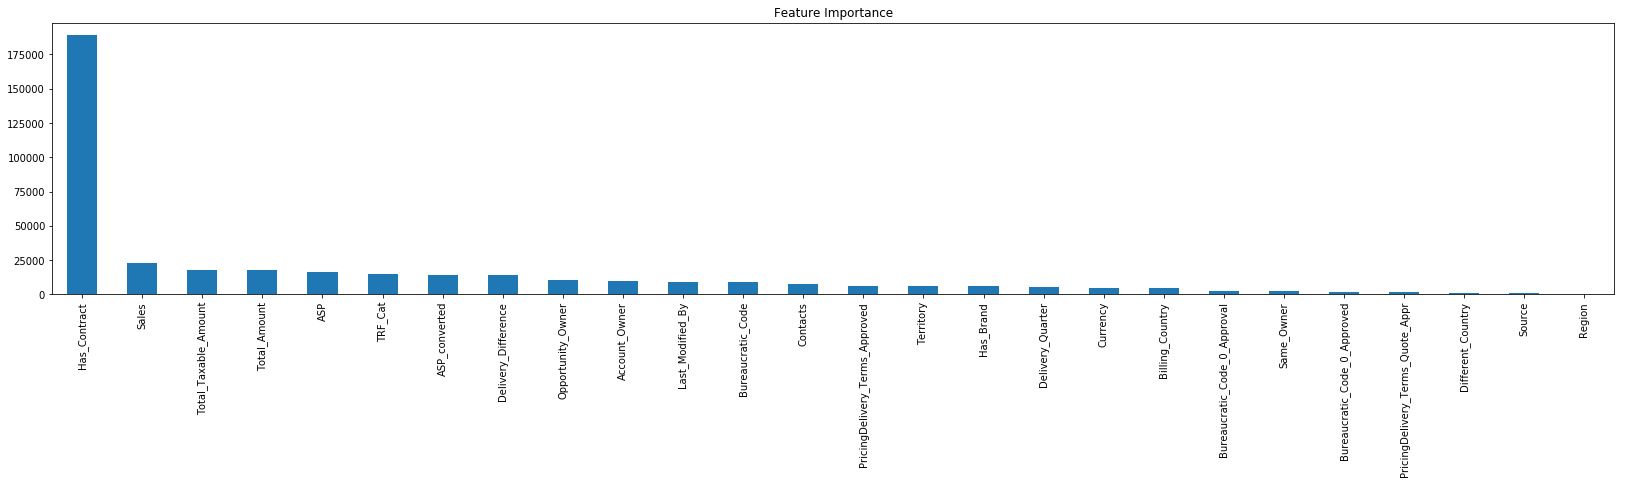

In [10]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [11]:
print feat_imp

Has_Contract                        188846.537967
Sales                                22870.539575
Total_Taxable_Amount                 17599.050198
Total_Amount                         17409.360767
ASP                                  16061.585380
TRF_Cat                              15152.947566
ASP_converted                        14376.548324
Delivery_Difference                  13923.957085
Opportunity_Owner                    10656.307641
Account_Owner                         9537.602699
Last_Modified_By                      9233.538532
Bureaucratic_Code                     8764.568654
Contacts                              7666.548513
PricingDelivery_Terms_Approved        6402.707346
Territory                             6248.152370
Has_Brand                             6074.279079
Delivery_Quarter                      5167.487637
Currency                              4484.955134
Billing_Country                       4346.177636
Bureaucratic_Code_0_Approval          2471.689140


In [59]:
y_pred = model.predict(x_test.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test = x_test.join(pred)
answer = x_test.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [60]:
log_loss(answer["Stage"], answer["Prediction"])

0.0789794338466508

In [61]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)

In [12]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission1.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9853548349001794

In [30]:
data[(data.Billing_Country != data.Territory) & (data.Territory != "None")].groupby("Stage")["Stage"].count()

Stage
0    2323
1    2225
Name: Stage, dtype: int64

In [31]:
data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")

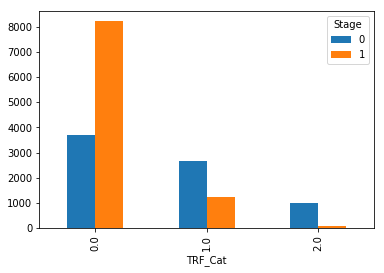

In [34]:
pd.crosstab(data.TRF_Cat, data.Stage).plot(kind = "bar")

In [7]:
df.groupby("Sales_Contract_No")["Sales_Contract_No"].count()

Sales_Contract_No
0          1
1          1
10         1
100        7
1000       1
1001       2
1002       1
1003       5
1004       5
1005       5
1006       5
1007       5
1008       1
1009       1
101        1
1010       2
1011       1
1012       1
1013       2
1014       1
1015       2
1016       2
1017       1
1018       2
1019       3
102        1
1020       1
1021       2
1022       1
1023       2
1024       2
1025       1
1026       2
1027       1
1028       2
1029       2
103        1
1030       2
1031       1
1032       1
1033       1
1034       1
1035       2
1036       1
1037       1
1038       1
1039       1
104        1
1040       1
1041       1
        ... 
954        2
955        1
956        1
958        1
959        1
96         1
960        1
961        1
962        1
963        1
964        1
965        1
966        1
967        1
968        1
969        1
97         3
970        1
971        1
972        1
973        1
974        1
975        1
976        2
977    

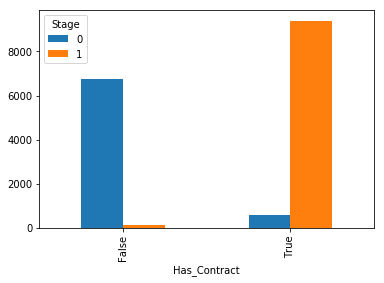

In [7]:
pd.crosstab(df.Has_Contract, df.Stage).plot(kind = "bar")

In [63]:
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A']
categorical = [x for x in categorical if x in df.columns]

full_data = lgb.Dataset(df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

full_model = lgb.train(parameters, full_data, num_boost_round = 5000)

In [67]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = full_model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer2 = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission1.csv")
prev["Prediction"].corr(answer2["Prediction"])

0.9804440034035615

In [68]:
answer["Prediction"].corr(answer2["Prediction"])

0.9904382797359162

In [70]:
answer2.to_csv("submission_9.csv", header = False, index = False)

In [15]:
df["Sales"] = df.groupby("Account_Name", sort = False)["Account_Name"].transform("count")

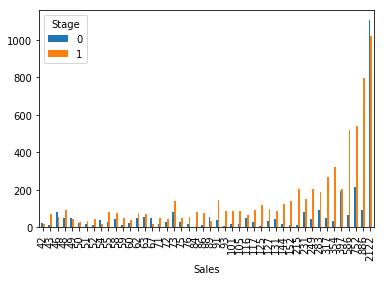

In [23]:
pd.crosstab(df[(df.Sales > 40) & (df.Sales > 40)].Sales, df[(df.Sales > 40) & (df.Sales > 40)].Stage).plot(kind = "bar")

In [72]:
for x in vali.Account_Owner.unique():
    if x not in df.Account_Owner.unique():
        print x

In [28]:
df["Product_Offer"] = df.groupby("Product_Family", sort = False)["Product_Family"].transform("count")

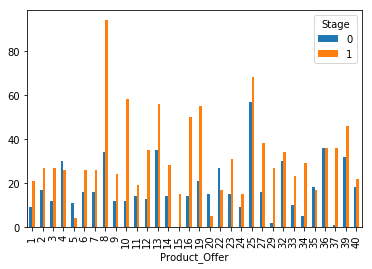

In [31]:
pd.crosstab(df[(df.Product_Offer <= 40) & (df.Product_Offer <= 40)].Product_Offer, df[(df.Product_Offer <= 40) & (df.Product_Offer <= 40)].Stage).plot(kind = "bar")

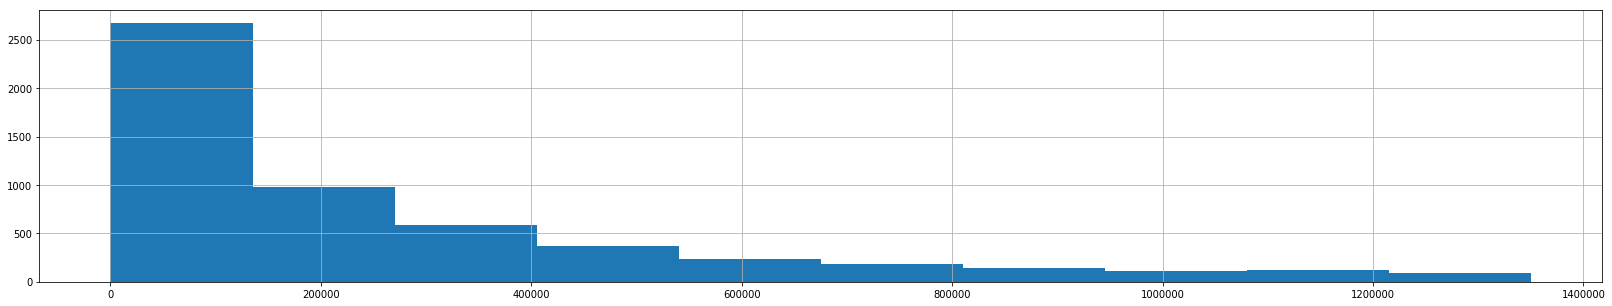

In [53]:
df[(df.Stage == 0) & (df.Total_Amount <= 1350000.0)].Total_Amount.hist()

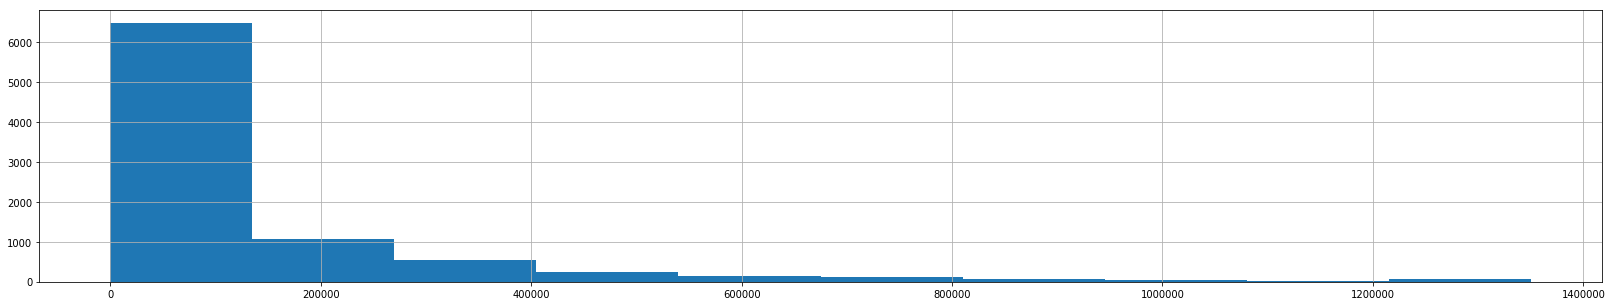

In [54]:
df[(df.Stage == 1)  & (df.Total_Amount <= 1350000.0)].Total_Amount.hist()

In [17]:
vali.Delivery_Quarter.value_counts()

Q2    1068
Q1     827
Q3     412
Q4     244
Name: Delivery_Quarter, dtype: int64

In [14]:
df.Currency.value_counts()

None    15988
EUR       475
USD       420
Name: Currency, dtype: int64

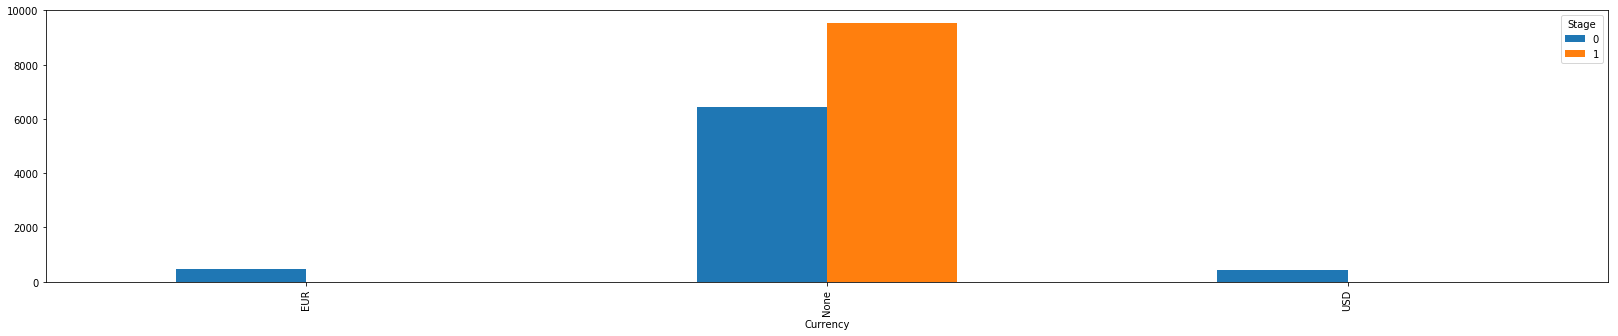

In [16]:
pd.crosstab(df.Currency, df.Stage).plot(kind = "bar")

In [18]:
df[df.Contacts > 1]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales
8,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,15600.00,470400.00,0,5,0.0,True,False,False,False,0.0,2122
9,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,4400.00,470400.00,0,5,0.0,True,False,False,False,0.0,2122
10,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,6200.00,470400.00,0,5,0.0,True,False,False,False,0.0,2122
11,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,140000.00,470400.00,0,5,0.0,True,False,False,False,0.0,2122
12,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,78.000,0.70125,Q1,304200.00,470400.00,0,5,0.0,True,False,False,False,0.0,2122
13,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,23400.00,559320.00,0,5,0.0,True,False,False,False,0.0,2122
14,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,4400.00,559320.00,0,5,0.0,True,False,False,False,0.0,2122
15,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,6200.00,559320.00,0,5,0.0,True,False,False,False,0.0,2122
16,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,NaN,NaN,Q1,140000.00,559320.00,0,5,0.0,True,False,False,False,0.0,2122
17,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,78.000,0.70125,Q1,385320.00,559320.00,0,5,0.0,True,False,False,False,0.0,2122


In [20]:
df.Source.value_counts()

None         9454
Source_7     2952
Source_9     1457
Source_11    1421
Source_13     783
Source_3      415
Source_1      137
Source_10     106
Source_2       86
Source_4       43
Source_6       19
Source_0        7
Source_12       2
Source_5        1
Name: Source, dtype: int64

In [25]:
validation.Source.value_counts()

None         1115
Source_7      701
Source_9      312
Source_11     204
Source_13     125
Source_3       40
Source_10      21
Source_2       13
Source_1       11
Source_6        6
Source_4        2
Source_5        1
Name: Source, dtype: int64